In [1]:
# Install required libraries
!pip install torch torchvision
!pip install torch-geometric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 32.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

#Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.nn import Linear, ReLU, BatchNorm1d, Dropout, Sequential
from torch_geometric.loader import DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter

#Data Processor Class

In [3]:
class DataProcessor:
    def __init__(self, file_path):
        self.df = pd.read_csv(file_path)
        self.le_subjects = LabelEncoder()
        self.le_career = LabelEncoder()
        self.le_filiere = LabelEncoder()
        self.le_diploma = LabelEncoder()
        self.scaler = StandardScaler()
        self.diploma_similarity = None
        self.diploma_info = {}
        self.diploma_names = []

    def get_encoders(self):
        return {
            'le_subjects': self.le_subjects,
            'le_career': self.le_career,
            'le_filiere': self.le_filiere,
            'le_diploma': self.le_diploma,
            'scaler': self.scaler
        }

    def safe_transform(self, encoder, value, label_type=None):
        """More robust transformation with detailed error handling"""
        if isinstance(value, list):
            # Handle list inputs
            return [self.safe_transform(encoder, v, label_type) for v in value]

        try:
            if value not in encoder.classes_:
                print(f"Warning: '{value}' not found in {label_type if label_type else 'encoder'} classes, using default value.")
                return 0
            return encoder.transform([value])[0]
        except (TypeError, ValueError) as e:
            print(f"Error transforming '{value}' ({type(value)}): {str(e)}")
            return 0

    def preprocess(self):
        def safe_literal_eval(value):
            """Safely convert string representations of lists to actual lists"""
            if pd.isna(value):
                return []
            if isinstance(value, list):
                return value
            try:
                value = str(value).strip()
                if value.startswith('[') and value.endswith(']'):
                    return ast.literal_eval(value.replace("'", '"'))
                elif ',' in value:
                    return [item.strip().strip("'\"") for item in value.split(',')]
                elif value:
                    return [value.strip("'\"")]
                return []
            except (ValueError, SyntaxError, AttributeError):
                return []

        # Convert columns to lists
        self.df['Matieres_Etudiant'] = self.df['Matieres_Etudiant'].apply(safe_literal_eval)
        self.df['Career'] = self.df['Career'].apply(safe_literal_eval)
        self.df['Employement_Opportunities'] = self.df['Employement_Opportunities'].apply(safe_literal_eval)
        self.df['Ancienne_Diplome'] = self.df['Ancienne_Diplome'].apply(safe_literal_eval)
        self.df['Matieres_Diplome'] = self.df['Matieres_Diplome'].apply(safe_literal_eval)
        self.df['Filiere'] = self.df['Filiere'].apply(safe_literal_eval)  # Treat Filiere as a list

        # Extract unique values
        all_subjects = list(set(subj for sublist in self.df['Matieres_Etudiant'] for subj in sublist))
        all_careers = list(set(career for sublist in self.df['Career'] for career in sublist))
        all_filieres = list(set(filiere for sublist in self.df['Filiere'] for filiere in sublist))

        # Fit encoders
        self.le_subjects.fit(all_subjects)
        self.le_career.fit(all_careers)
        self.le_filiere.fit(all_filieres)
        self.le_diploma.fit(self.df['Nom_Diplôme'].unique().tolist())

        # Map Bac mentions to numerical values
        mention_map = {'Mention Très Bien': 3, 'Bien': 2, 'Assez Bien': 1, 'Passable': 0}
        self.df['Mention_Bac'] = self.df['Mention_Bac'].map(mention_map).fillna(0)

        # Handle missing values for non-list columns
        for col in ['Durée', 'Ville']:
            if self.df[col].isnull().any():
                mode_val = self.df[col].mode()[0]
                print(f"Warning: Missing values in {col} filled with: {mode_val}")
                self.df[col] = self.df[col].fillna(mode_val)

        # Scale duration
        self.scaler.fit(self.df[['Durée']].values.reshape(-1, 1))
        self.df['Durée_scaled'] = self.scaler.transform(self.df[['Durée']].values.reshape(-1, 1))

        return self.df

    def create_graphs(self):
        data_list = []
        subject_dim = len(self.le_subjects.classes_)
        career_dim = len(self.le_career.classes_)
        filiere_dim = len(self.le_filiere.classes_)

        # Store diploma info
        self.diploma_info = {}
        for _, row in self.df.iterrows():
            diploma = row['Nom_Diplôme']
            self.diploma_info[diploma] = {
                'Durée': float(row['Durée']),
                'Career': set(row['Career']),
                'Matieres_Etudiant': set(row['Matieres_Etudiant']),
                'Filiere': set(row['Filiere']),  # Multiple Filiere values as a set
                'Mention_Bac': row['Mention_Bac']
            }

        # Create diploma similarity matrix (optional, retained from original)
        diploma_features = {}
        self.diploma_names = list(self.diploma_info.keys())
        for diploma in self.diploma_names:
            diploma_df = self.df[self.df['Nom_Diplôme'] == diploma].iloc[0]
            feature_vector = np.zeros(subject_dim + career_dim + 1)
            feature_vector[0] = diploma_df['Durée']
            for subj in diploma_df['Matieres_Etudiant']:
                feature_vector[1 + self.le_subjects.transform([subj])[0]] = 1
            for career in diploma_df['Career']:
                feature_vector[1 + subject_dim + self.le_career.transform([career])[0]] = 1

            diploma_features[diploma] = feature_vector

        feature_matrix = np.array([diploma_features[d] for d in self.diploma_names])
        similarity = cosine_similarity(feature_matrix)
        self.diploma_similarity = np.zeros_like(similarity)
        for i, d1 in enumerate(self.diploma_names):
            for j, d2 in enumerate(self.diploma_names):
                if i != j and (self.diploma_info[d1]['Durée'] == self.diploma_info[d2]['Durée'] and
                                len(self.diploma_info[d1]['Career'] & self.diploma_info[d2]['Career']) > 0):
                    self.diploma_similarity[i, j] = similarity[i, j]

        # Create graph for each row
        for _, row in self.df.iterrows():
            num_nodes = (1 + len(row['Matieres_Etudiant']) +
                         len(row['Career']) + len(row['Filiere']))
            x = torch.zeros((num_nodes, 5 + subject_dim + career_dim + filiere_dim), dtype=torch.float)

            # Root node
            x[0, 0] = row['Durée_scaled']
            x[0, 1] = row['Mention_Bac']

            edges = []
            # Subject nodes
            subj_start = 1
            for i, subject in enumerate(row['Matieres_Etudiant'], subj_start):
                subj_idx = self.le_subjects.transform([subject])[0]
                x[i, 2 + filiere_dim + subj_idx] = 1
                edges.extend([[0, i], [i, 0]])

            # Filiere nodes (multiple values)
            filiere_start = subj_start + len(row['Matieres_Etudiant'])
            for i, filiere in enumerate(row['Filiere'], filiere_start):
                filiere_idx = self.le_filiere.transform([filiere])[0]
                x[i, 2 + filiere_idx] = 1
                edges.extend([[0, i], [i, 0]])

            # Career nodes
            career_start = filiere_start + len(row['Filiere'])
            for i, career in enumerate(row['Career'], career_start):
                career_idx = self.le_career.transform([career])[0]
                x[i, 2 + filiere_dim + subject_dim + career_idx] = 1
                edges.extend([[0, i], [i, 0]])

            edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
            y = torch.tensor([self.le_diploma.transform([row['Nom_Diplôme']])[0]], dtype=torch.long)
            data_list.append(Data(x=x, edge_index=edge_index, y=y))

        return data_list

    def get_related_diplomas(self, diploma_name, top_n=3, threshold=0.7):
        if self.diploma_similarity is None or diploma_name not in self.diploma_names:
            return []
        idx = self.diploma_names.index(diploma_name)
        similarities = self.diploma_similarity[idx]
        related_indices = np.where(similarities > threshold)[0]
        related_scores = [(self.diploma_names[i], similarities[i])
                            for i in related_indices if i != idx]
        related_scores.sort(key=lambda x: x[1], reverse=True)
        return related_scores[:top_n]


#Graph neural network

In [4]:
class DiplomaGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm1d(hidden_channels)
        self.classifier = Sequential(
            Linear(hidden_channels, hidden_channels//2),
            ReLU(),
            Dropout(0.3),
            Linear(hidden_channels//2, out_channels)
        )

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = global_mean_pool(x, batch)
        return self.classifier(x)

#GNN Trainer Class

In [13]:
class GNNTrainer:
    def __init__(self, model, train_loader, test_loader, le_diploma, encoders, processor):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.le_diploma = le_diploma
        self.processor = processor
        self.le_subjects = encoders['le_subjects']
        self.le_career = encoders['le_career']
        self.le_filiere = encoders['le_filiere']
        self.scaler = encoders['scaler']

        # Class weights
        if train_loader is not None:
            class_counts = torch.bincount(torch.tensor([data.y.item() for data in train_loader.dataset]))
            class_counts = torch.clamp(class_counts, min=1)
            self.weights = (1. / class_counts.float()).to(self.device)
        else:
            self.weights = None
    def evaluate(self):
        if self.test_loader is None:
            return 0, 0
        self.model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for batch in self.test_loader:
                batch = batch.to(self.device)
                pred = self.model(batch).argmax(dim=1)
                all_preds.extend(pred.cpu().numpy())
                all_labels.extend(batch.y.cpu().numpy())

        # Get the unique classes that appear in the test set
        unique_labels = sorted(set(all_labels))
        target_names = [self.le_diploma.classes_[i] for i in unique_labels]

        # Check if we have any predictions to evaluate
        if len(all_preds) == 0 or len(unique_labels) <= 1:
            return 0, 0

        report = classification_report(
            all_labels, all_preds,
            labels=unique_labels,  # Specify which labels to include
            target_names=target_names,
            output_dict=True,
            zero_division=0
        )

        # The structure of the report changes when we use labels parameter
        # For overall accuracy, we need to use the special key 'accuracy'
        accuracy = report.get('accuracy', 0)
        macro_f1 = report.get('macro avg', {}).get('f1-score', 0)

        return accuracy, macro_f1

    def train(self, num_epochs=100):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10)
        loss_func = torch.nn.CrossEntropyLoss(weight=self.weights)

        train_losses = []  # This will store our loss values

        try:
            for epoch in range(num_epochs):
                self.model.train()
                total_loss = 0
                for batch in self.train_loader:
                    batch = batch.to(self.device)
                    optimizer.zero_grad()
                    out = self.model(batch)
                    loss = loss_func(out, batch.y)
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                    optimizer.step()
                    total_loss += loss.item()

                avg_loss = total_loss / len(self.train_loader)
                train_losses.append(avg_loss)  # Store the loss for this epoch

                if epoch % 10 == 0:
                    print(f'Epoch {epoch}: Loss: {avg_loss:.4f}')

            # After training completes, plot the loss
            self.plot_loss(train_losses)

        except Exception as e:
            print(f"Error during training: {str(e)}")
            torch.save(self.model.state_dict(), 'latest_diploma_model.pt')
            # Still plot whatever loss values we have
            self.plot_loss(train_losses)

        return train_losses

    def plot_loss(self, losses):
        plt.figure(figsize=(10, 5))
        plt.plot(losses, label='Training Loss', color='blue')
        plt.title('Training Loss Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    def predict(self, features, scaler, desired_duree=None):
        self.model.eval()
        subject_dim = len(self.le_subjects.classes_)
        career_dim = len(self.le_career.classes_)
        filiere_dim = len(self.le_filiere.classes_)

        # Data validation
        if 'Matieres_Etudiant' not in features or not features['Matieres_Etudiant']:
            features['Matieres_Etudiant'] = []
            print("Warning: No subjects provided, predictions may be less accurate")

        if 'Career' not in features:
            features['Career'] = []

        # Handle single Filiere input from user
        if 'Filiere' not in features or not features['Filiere']:
            features['Filiere'] = []
            print("Warning: No filiere provided, predictions may be less accurate")

        user_filiere = [features['Filiere']] if isinstance(features['Filiere'], str) else features['Filiere']
        user_careers = set(features.get('Career', []))
        career_missing = len(user_careers) == 0
        duration_missing = desired_duree is None or desired_duree == 0

        # Create graph
        num_nodes = 1 + len(features['Matieres_Etudiant']) + len(features['Career']) + len(user_filiere)
        x = torch.zeros((num_nodes, 5 + subject_dim + career_dim + filiere_dim), dtype=torch.float)

        # Set duration
        try:
            duration = features.get('Durée', 0)
            x[0, 0] = scaler.transform(np.array([[duration]]))[0][0]
        except Exception as e:
            print(f"Error setting duration: {str(e)}")
            x[0, 0] = 0

        # Set bac mention
        mention_map = {'Mention Très Bien': 3, 'Bien': 2, 'Assez Bien': 1, 'Passable': 0}
        x[0, 1] = mention_map.get(features.get('Mention_Bac', ''), 0)

        edges = []
        # Add nodes and edges with better error handling
        try:
            # Subject nodes
            subj_start = 1
            for i, subject in enumerate(features['Matieres_Etudiant'], subj_start):
                subj_idx = self.processor.safe_transform(self.le_subjects, subject, 'subject')
                x[i, 2 + filiere_dim + subj_idx] = 1
                edges.extend([[0, i], [i, 0]])

            # Filiere node (single value from user)
            filiere_start = subj_start + len(features['Matieres_Etudiant'])
            for i, filiere in enumerate(user_filiere, filiere_start):
                filiere_idx = self.processor.safe_transform(self.le_filiere, filiere, 'filiere')
                x[i, 2 + filiere_idx] = 1
                edges.extend([[0, i], [i, 0]])

            # Career nodes
            career_start = filiere_start + len(user_filiere)
            for i, career in enumerate(features['Career'], career_start):
                career_idx = self.processor.safe_transform(self.le_career, career, 'career')
                x[i, 2 + filiere_dim + subject_dim + career_idx] = 1
                edges.extend([[0, i], [i, 0]])
        except Exception as e:
            print(f"Error building graph: {str(e)}")
            # Provide minimal graph if building fails
            if not edges and num_nodes > 1:
                edges = [[0, 1], [1, 0]]

        # Ensure we have at least one edge
        if not edges and num_nodes > 1:
            edges = [[0, 1], [1, 0]]
        elif not edges:
            # Add a self-loop if we have only one node
            edges = [[0, 0]]

        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        data = Data(x=x, edge_index=edge_index, batch=torch.zeros(num_nodes, dtype=torch.long)).to(self.device)

        # Make prediction with error handling
        try:
            with torch.no_grad():
                out = self.model(data)
                probs = F.softmax(out, dim=1)[0]
        except Exception as e:
            print(f"Error during model prediction: {str(e)}")
            return ["Error during prediction"]

        valid_predictions = []
        for i, prob in enumerate(probs):
            diploma_name = self.le_diploma.inverse_transform([i])[0]
            diploma_info = self.processor.diploma_info[diploma_name]
            diploma_row = self.processor.df[self.processor.df['Nom_Diplôme'] == diploma_name].iloc[0]

            # Check if user's Filiere is in diploma's Filiere set
            filiere_match = any(f in diploma_info['Filiere'] for f in user_filiere)
            duration_match = duration_missing or (desired_duree is not None and desired_duree > 0 and diploma_info['Durée'] == desired_duree)
            career_match = career_missing or len(user_careers & diploma_info['Career']) > 0

            if filiere_match and duration_match and career_match:
                valid_predictions.append({
                    'Nom': diploma_name,
                    'Ecole': diploma_row['Ecole'],
                    'Durée': diploma_info['Durée'],
                    'Filiere': list(diploma_info['Filiere']),
                    'score': probs[i].item()  # Add probability score
                })

        if not valid_predictions:
            return ["No matching diplomas found"]

        # Sort by probability (descending) and return only the details
        valid_predictions.sort(key=lambda x: probs[self.le_diploma.transform([x['Nom']])[0]], reverse=True)

        # Get unique diplomas and limit to top 5
        seen = set()
        final_predictions = []
        for pred in valid_predictions:
            if pred['Nom'] not in seen:
                final_predictions.append(pred)
                seen.add(pred['Nom'])
                if len(final_predictions) >= 5:
                    break

        return final_predictions


#Main Execution

Size of preprocessed DataFrame: (390, 12)
Diploma counts:
 Nom_Diplôme
Licence en Informatique                    16
Licence en Droit                           14
Licence en Études Arabes                   12
Licence en Sciences Économiques            12
Licence en Physique                        11
                                           ..
Master en Design Graphique                  1
Bachelor en Génie Informatique              1
Bachelor en Études Internationales          1
Master en Psychologie Sociale               1
Bachelor en Administration des Affaires     1
Name: count, Length: 131, dtype: int64
Label distribution: Counter({42: 16, 33: 14, 57: 12, 52: 12, 22: 11, 129: 11, 130: 11, 46: 11, 58: 10, 40: 10, 23: 10, 31: 9, 20: 9, 26: 7, 30: 7, 128: 6, 56: 6, 123: 6, 124: 6, 35: 6, 39: 6, 72: 5, 109: 5, 38: 5, 55: 4, 15: 4, 5: 4, 6: 4, 53: 4, 87: 4, 19: 4, 111: 4, 45: 3, 105: 3, 86: 3, 44: 3, 54: 3, 118: 3, 14: 3, 25: 3, 125: 3, 126: 3, 127: 3, 12: 3, 119: 3, 0: 3, 91: 2, 110: 

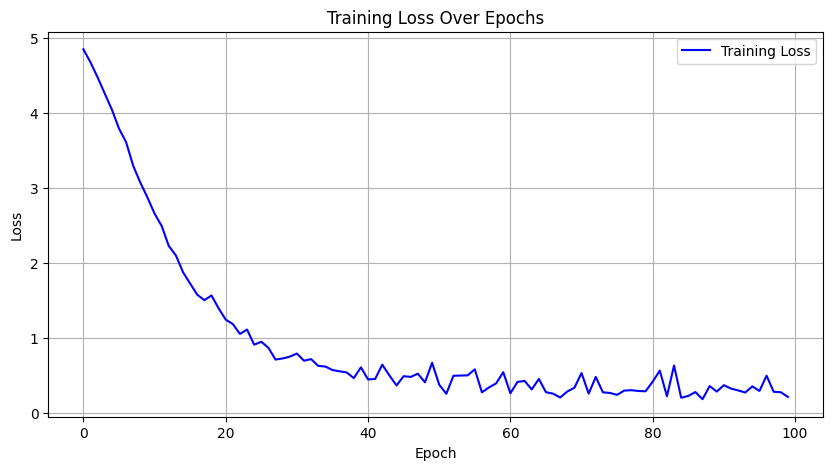

In [14]:
if __name__ == "__main__":
    # Main execution
    processor = DataProcessor('data.csv')
    df = processor.preprocess()
    print("Size of preprocessed DataFrame:", df.shape)
    print("Diploma counts:\n", df['Nom_Diplôme'].value_counts())

    graph_data = processor.create_graphs()
    encoders = processor.get_encoders()

    # Debug label distribution
    label_counts = Counter([d.y.item() for d in graph_data])
    print("Label distribution:", label_counts)

    # Train-test split logic
    min_samples_per_class = 2
    min_total_samples = 20
    total_samples = len(graph_data)
    classes_with_enough_samples = sum(1 for count in label_counts.values() if count >= min_samples_per_class)

    if total_samples >= min_total_samples and classes_with_enough_samples >= len(label_counts) * 0.5:
        valid_labels = {label for label, count in label_counts.items() if count >= min_samples_per_class}
        filtered_graph_data = [data for data in graph_data if data.y.item() in valid_labels]
        if len(filtered_graph_data) < min_total_samples:
            train_data = graph_data
            test_data = None
            train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
            test_loader = None
        else:
            train_data, test_data = train_test_split(
                filtered_graph_data,
                test_size=0.3,
                stratify=[d.y.item() for d in filtered_graph_data]
            )
            train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
            test_loader = DataLoader(test_data, batch_size=32)
    else:
        train_data = graph_data
        test_data = None
        train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
        test_loader = None

    # Model setup
    model = DiplomaGNN(
        in_channels=train_data[0].x.shape[1],
        hidden_channels=128,
        out_channels=len(processor.le_diploma.classes_)
    )

    trainer = GNNTrainer(model, train_loader, test_loader, processor.le_diploma, encoders, processor)
    best_f1 = trainer.train(num_epochs=100)

In [16]:
features = {
        'Matieres_Etudiant': ['Informatique'],
        'Career': ['Informatique'],
        'Filiere': 'SM',  # Single value from user
        'Durée': 5,
        'Mention_Bac': 'Mention Très Bien'
    }
predictions = trainer.predict(features, processor.scaler, desired_duree=5)
for pred in predictions:
    print(f"Diploma: {pred['Nom']}")
    print(f"School: {pred['Ecole']}")
    print(f"Duration: {pred['Durée']} years")
    print(f"Fields: {', '.join(pred['Filiere'])}")
    print(f"Prediction Score: {pred['score']}")  # Display the probability score
    print("-" * 40)

Diploma: Ingénieur en Data Science
School: ENSIAS
Duration: 5.0 years
Fields: SP, SM
Prediction Score: 0.9265848398208618
----------------------------------------
Diploma: Ingénieur en Génie Informatique
School: ENSA-BM
Duration: 5.0 years
Fields: SP, SM
Prediction Score: 0.044310785830020905
----------------------------------------
Diploma: Ingénieur en Cybersécurité
School: ENSA-Fès
Duration: 5.0 years
Fields: SP, SM
Prediction Score: 0.0193973109126091
----------------------------------------
Diploma: Ingénieur en Télécommunications
School: INPT
Duration: 5.0 years
Fields: SP, SM, STE
Prediction Score: 0.0005210366798564792
----------------------------------------
Diploma: Ingénieur en Intelligence Artificielle
School: EI-UIR
Duration: 5.0 years
Fields: SP, SM
Prediction Score: 4.0040842863575676e-10
----------------------------------------
